In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from utils import *
update_plot_defaults()

# Na channels: current-voltage relationship (I-V)

## 1. Choose the data file you want to analyze

#### Put the .abf files with your Na channel recordings in the "data/Na_channels" folder

In [124]:
data_folder = "data/Na_channels"

from glob import glob
data_files = glob(data_folder+"/*.abf")
print(data_folder)
data_files

data/Na_channels


['data/Na_channels/nav18-iv.abf',
 'data/Na_channels/nav18-ssinact.abf',
 'data/Na_channels/nav18-nav_recovery.abf',
 'data/Na_channels/NAV_Tho(1)_21309013.abf',
 'data/Na_channels/NAV_Cerv(3)_22712021.abf',
 'data/Na_channels/NAV_Tho(2)_21309018.abf',
 'data/Na_channels/NAV_Cerv(1)_22712019.abf',
 'data/Na_channels/NAV_Cerv(2)_22712020.abf',
 'data/Na_channels/NAV_Lomb(1)_22919024.abf',
 'data/Na_channels/NAV_Lomb(2)_22919023.abf']

Choose which file you want to analyze and past the file name here:

In [ ]:
data_file = 'data/Na_channels/nav18-iv.abf'

Now we can load the file and plot the raw data:

Data dimensions (sweeps, channels, timepoints): 
(26, 2, 5160)
sampling freq: 99999.99999999999 Hz


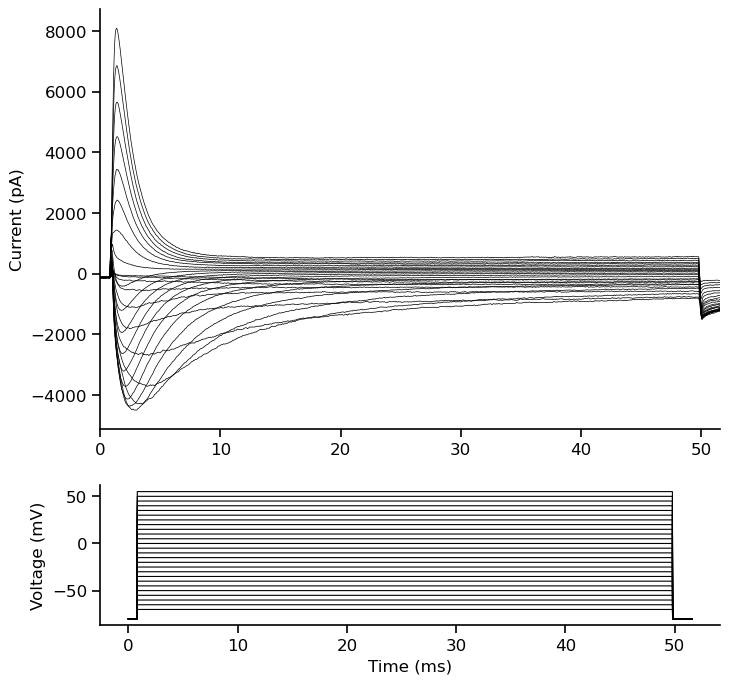

In [127]:
## Extract the sweeps, time and sampling frequency:
sweeps, sweeps_time, sampling_freq = get_sweeps(data_file)

print(f"Data dimensions (sweeps, channels, timepoints): \n{sweeps.shape}")
print(f"sampling freq: {sampling_freq} Hz")

current_traces = sweeps[:, 0, :]
voltage_traces = sweeps[:, 1, :]
ax = plot_traces(sweeps_time, current_traces, voltage_traces)
plt.show()

## 2. Select what you want to measure

### 2.1. Defining the time window

First let's define the relevant time window where we want to measure the currents:

(If you want to save the images, you can do it by clicking on the save icon in the top-right of the image when you hover over it)

array([<Axes: ylabel='Current (pA)'>,
       <Axes: xlabel='Time (ms)', ylabel='Voltage (mV)'>], dtype=object)

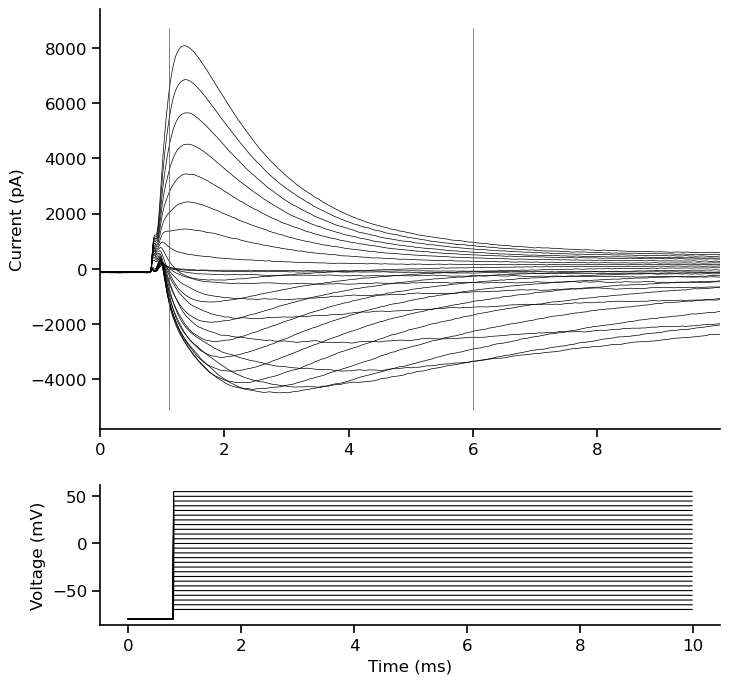

In [135]:
# The start/end time just helps to zoom in on the traces.
start_time = 0  # milliseconds
end_time = 10   # milliseconds, (enter -1 to get the end of the sweep)

# The markers are important: the will define the window where we actually exctract peak current values from. Set them carefully.
marker_1 = 1.1  # milliseconds
marker_2 = 6    # milliseconds

current_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=0)
voltage_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=1)

ax = plot_traces(time_in_window, current_traces, voltage_traces, marker_1, marker_2)
plt.show()

### 3.1. Optional: apply baseline correction

If your baseline current is not zero, you may need to correct for that to get accurate measurements.

Uncomment this cell block (highlight everything, then cmd+/ on macOS or ctrl+/ on Windows) to run it.

In [ ]:
# # Measure baseline: you need to specify which part of the trace you want to use for baseline measurement.
# start_time = 0 # milliseconds
# end_time = 0.5 # milliseconds
# measurement_type = 'mean' # Options: 'mean', 'max', 'min'

# baseline_voltage, baseline_current = get_step_measurements(sweeps, sweeps_time, start_time, end_time, sampling_freq, measurement_type)

# # Subtract baseline from the sweeps
# num_traces = sweeps.shape[0]
# for i in range(num_traces):
#     sweeps[i,0] -= baseline_current[i]

### 3.2. Measure currents

Here we will be using the timepoints from the markers we defined above.

In [ ]:
measurement_type = 'peak' # Options: 'mean', 'max', 'min', 'peak'

voltage_steps, current_steps = get_step_measurements(sweeps, sweeps_time, 
                                                     start_time=marker_1,
                                                     end_time=marker_2,
                                                     sampling_freq=sampling_freq,
                                                     measurement_type=measurement_type)

ax = plot_IV(voltage_steps, current_steps, xlabel_coords=(0.95,0.25), ylabel_coords=(0.4,0.6))
plt.show()

### 3.3. Optional: fit a line to the I-V points

If our data is noisy, we can get an estimate of the reversal potential by fitting a line to the data and finding where it intersects the x-axis.

The slope of the line will also give us an estimate of the conductance.

G = slope = 194.904 nS
Resistance = 1/slope = 5.131 MOhm
Reversal potential: 16.422 mV


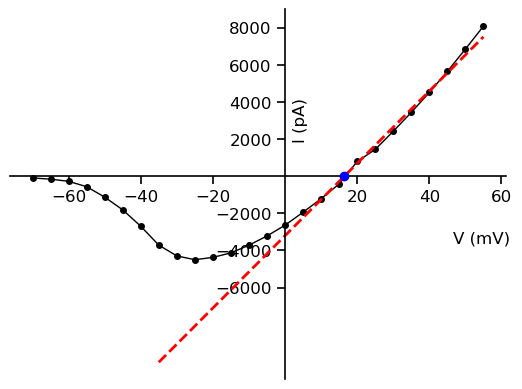

In [141]:
# Here it is important to select a range of points in the "linear" part of the IV curve, where the Na channels are open.
points_start = 15
points_end = -1  # (-1 here means the last point in the array)


# Fit a line to the points
ax = plot_IV(voltage_steps, current_steps, xlabel_coords=(0.95,0.4), ylabel_coords=(0.6,0.7))
from scipy.stats import linregress
voltage_steps_to_fit = voltage_steps[points_start:points_end]
current_steps_to_fit = current_steps[points_start:points_end]
slope, intercept, r_value, p_value, std_err = linregress(voltage_steps_to_fit, current_steps_to_fit)
ax.plot(voltage_steps[7:], slope * voltage_steps[7:] + intercept, linestyle='--', color='r', label='Fit', linewidth=2)

print(f"G = slope = {slope:.3f} nS")
print(f"Resistance = 1/slope = {1/slope * 1000:.3f} MOhm")

# Find the intercept on the x-axis (where current is zero)
V_rev = -intercept / slope
ax.scatter(V_rev, 0, color='b', zorder=5)
print(f"Reversal potential: {V_rev:.3f} mV")

### 3.4. Optional: Calculate the channel activation curve 
#### (open probability of the channel, when we factor in the changing driving force at different voltages)

<img src="images/Na_IV_activation_analysis.png" width="600">


Here we are channel activation by calculating the conductance of the channel at different voltages and normalizing against the maximum conductance.

Note that we are estimating the G from single points, so errors will be larger close to the reversal potential (where our calculation is very sensitive to small variations in V-E_rev).


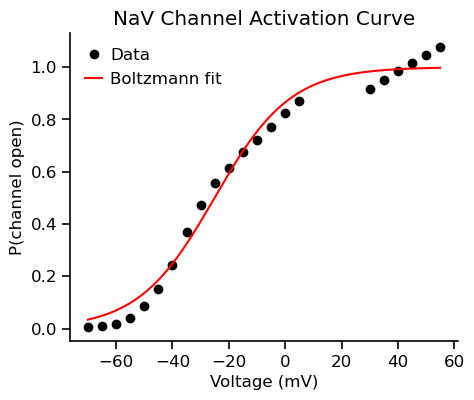

In [154]:
# Shift the values to the left so the reversal potential is at zero (i.e. curve passes through the origin)
# Then the conductance can be calculated at each point

# Remove the points within 5mv of the reversal potential
# This is because the conductance is not well defined at the reversal potential
delta_V = voltage_steps - V_rev
mask = np.abs(delta_V) > 5
voltage_steps = voltage_steps[mask]
current_steps = current_steps[mask]

# Calculate the conductance at each point
G = current_steps / (voltage_steps - V_rev)

# Now we normalize these conductances by the maximum value, i.e. the fully open channel conductance
# G_max = np.max(G) # We could use the maximum value, but this measurement is a bit noisy 
G_max = slope # We can also use the slope of the linear fit (in the open part of the curve) as the maximum conductance
G_norm = G / G_max

# Finally we can fit the Boltzmann function (sigmoidal curve) to the data 
from scipy.optimize import curve_fit
def boltzmann(V, V_half, k):
    return 1 / (1 + np.exp((V_half - V) / k))
k_guess = 5 # Initial guess for the slope parameter
popt, _ = curve_fit(boltzmann, voltage_steps, G_norm, p0=[np.median(voltage_steps), k_guess])
V_half_fit, k_fit = popt
V_fit = np.linspace(np.min(voltage_steps), np.max(voltage_steps), 500)
G_fit = boltzmann(V_fit, V_half_fit, k_fit)

# Plot normalized data points & fitted curve
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(voltage_steps, G_norm, 'o', label='Data', color='black')
ax.plot(V_fit, G_fit, '-', label='Boltzmann fit', color='red')
ax.set_xlabel('Voltage (mV)')
ax.set_ylabel('P(channel open)')
ax.set_title('NaV Channel Activation Curve')
ax.legend(handlelength=1, loc='upper left', handletextpad=0.5)
plt.show()